# Capstone

## Research Question 1: Mortality Prediction in ICU 

Objective: To assess the role of machine learning algorithms for predicting mortality by using the MIMIC-III dataset. 

Question: Is it possible to accurately **predict mortality** based on data from the **first 24 hours in ICU**?

## Research Question 2: Weekend Effect in ICU 

Objective: To develop a statistical model to estimate the effect of **weekend admission to ICU** on the **risk of ICU mortality**. 

Question: Does admission to ICU over the weekend increase the risk of mortality? 

In [94]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import math
import datetime
from sklearn import preprocessing
from utils import *

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [95]:
FILE_PATH = 'raw_data/'
FILE_EXTENSION = '.csv'
INPUT_DATA_DIR = 'input/input.csv'
STARTING_TABLES  = \
['pt_icu_outcome', 'vitals_hourly', 'labs_hourly', 
 'gcs_hourly', 'admissions', 'output_hourly']
FILE_DIR = [FILE_PATH + name + FILE_EXTENSION for name in STARTING_TABLES]

# data ingestion
raw_icu = pd.read_csv(FILE_DIR[0])
raw_vitals = pd.read_csv(FILE_DIR[1])
raw_labs = pd.read_csv(FILE_DIR[2])
raw_gcs = pd.read_csv(FILE_DIR[3]) #Glasgow Coma Score
raw_ad = pd.read_csv(FILE_DIR[4])

# ETL - admission
pt_icu_cleaned = pt_icu_etl(raw_icu)
admission_cleaned = admission_etl_function(raw_ad)
first_24_vital_agg = hourly_vitals_etl(raw_vitals)
first_24_gcs_agg = hourly_gcs_etl(raw_gcs)
first_24_labs_agg = hourly_labs_etl(raw_labs)

icu_n_admission = pd.merge(pt_icu_cleaned, 
                           admission_cleaned, 
                           how='inner', on='hadm_id')
icu_n_vital = pd.merge(icu_n_admission, 
                       first_24_vital_agg, 
                       how='inner', on='icustay_id')
icu_n_gcs = pd.merge(icu_n_vital, 
                     first_24_gcs_agg, 
                     how='inner', on='icustay_id')
icu_n_labs = pd.merge(icu_n_gcs, 
                      first_24_labs_agg, 
                      how='inner', on='icustay_id')

cols_to_drop_final = \
['row_id', 'dob', 'hadm_id', 'subject_id', 'admittime', 'dischtime',
 'icustay_id', 'age_years', 'intime', 'outtime','hosp_deathtime',
 'icu_expire_flag', 'hospital_expire_flag', 'dod', 'expire_flag',
 'ttd_days', 'icu_adm_weekend', 'ttd_bins']
pt_icu_final = icu_n_labs.drop(cols_to_drop_final, axis=1)
pt_icu_final.to_pickle("input/input.pkl")

Label Balance in counts:
False    47368
True      3697
Name: standard_mortality_label, dtype: int64
Label Balance in ratio:
False   0.9276
True    0.0724
Name: standard_mortality_label, dtype: float64


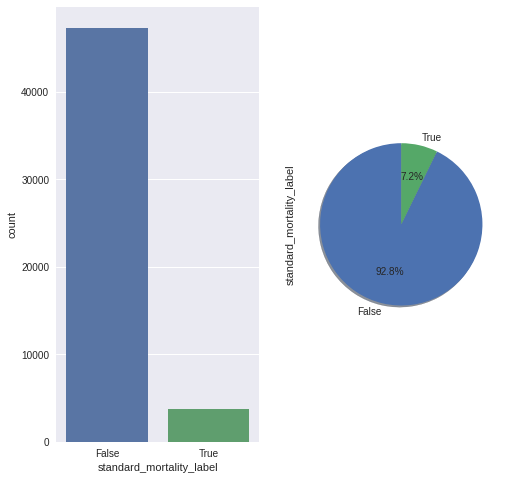

In [96]:
df = pd.read_pickle("input/input.pkl")

labels = [False, True]
fig, ax = plt.subplots(1,2, figsize=(8,8))
sns.countplot(df['standard_mortality_label'], ax=ax[0])
df.standard_mortality_label.value_counts().\
    plot.pie(labels=labels, autopct='%.1f%%', shadow=True, startangle=90)
print('Label Balance in counts:')
print(df.standard_mortality_label.value_counts())
print('Label Balance in ratio:')
print(df.standard_mortality_label.value_counts(normalize=True))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
los,51065.0000,NaN,NaN,NaN,4.2277,6.1909,0.1825,1.2473,2.1878,4.2704,173.0725
age_bins_under20,51065.0000,NaN,NaN,NaN,0.0109,0.1041,0.0000,0.0000,0.0000,0.0000,1.0000
age_bins_20-40,51065.0000,NaN,NaN,NaN,0.0949,0.2931,0.0000,0.0000,0.0000,0.0000,1.0000
age_bins_40-60,51065.0000,NaN,NaN,NaN,0.2946,0.4559,0.0000,0.0000,0.0000,1.0000,1.0000
age_bins_60-80,51065.0000,NaN,NaN,NaN,0.4185,0.4933,0.0000,0.0000,0.0000,1.0000,1.0000
...,...,...,...,...,...,...,...,...,...,...,...
abnorm_glucose,51065.0000,NaN,NaN,NaN,0.2793,0.7990,0.0000,0.0000,0.0000,0.0000,17.0000
abnorm_neutrophil,51065.0000,NaN,NaN,NaN,0.1930,0.4465,0.0000,0.0000,0.0000,0.0000,5.0000
abnorm_creactiveprotein,51065.0000,NaN,NaN,NaN,0.0067,0.0852,0.0000,0.0000,0.0000,0.0000,2.0000
abnorm_lactate,51065.0000,NaN,NaN,NaN,0.8458,1.6953,0.0000,0.0000,0.0000,1.0000,21.0000


<Figure size 432x288 with 0 Axes>

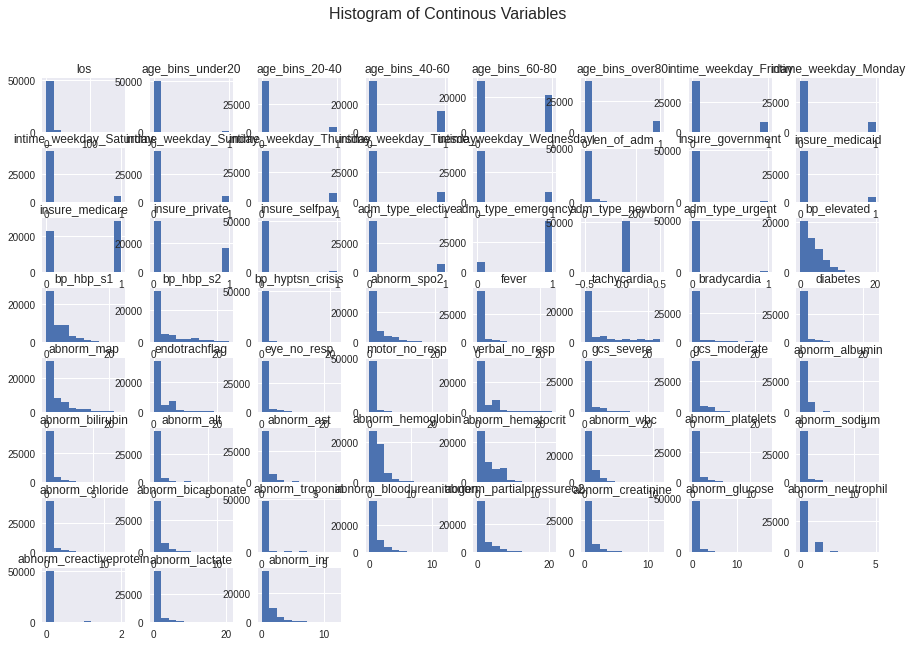

In [97]:
TARGETS = ['standard_mortality_label']
# fast data inspection
display(df.drop(TARGETS, axis=1).describe(include='all').T)
fig= plt.figure()
df.drop(TARGETS, axis=1).hist(figsize=(15,10))
plt.suptitle('Histogram of Continous Variables', size = 16)
plt.show()

In [184]:
x = X.nunique()
CATEGORICAL_4_VIZ = list(x[x==2].index)
CONTINUOUS_4_VIZ = [x for x in df.columns if x not in CATEGORICAL_4_VIZ]
#df[list(x[x==2].index)]

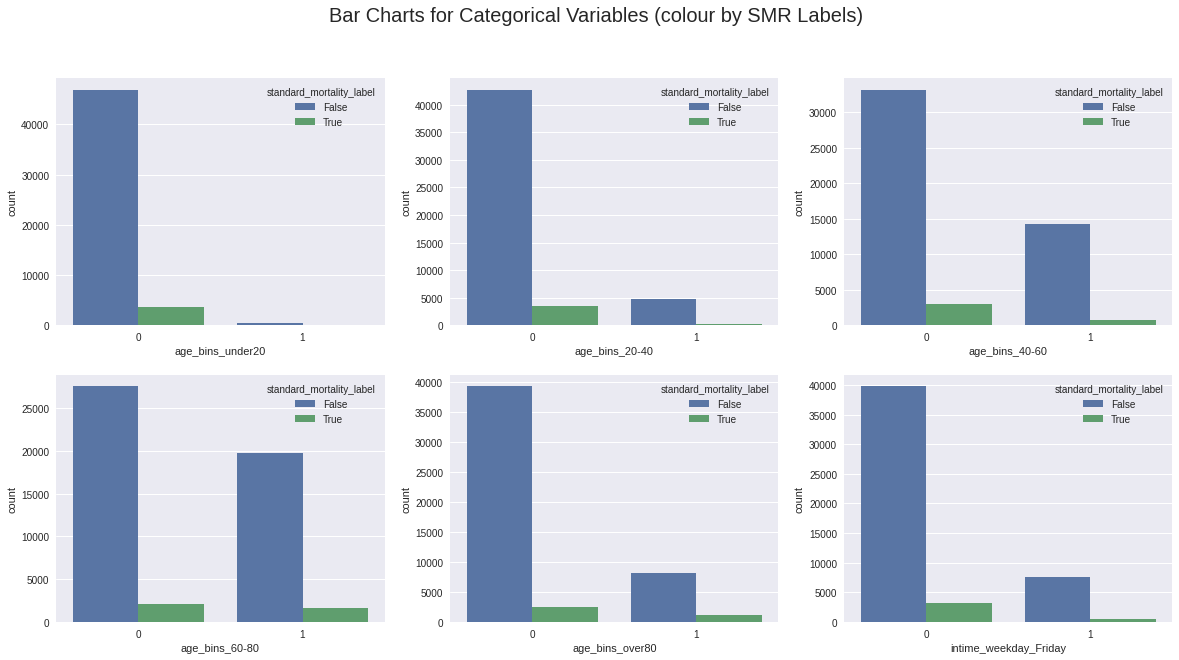

No handles with labels found to put in legend.


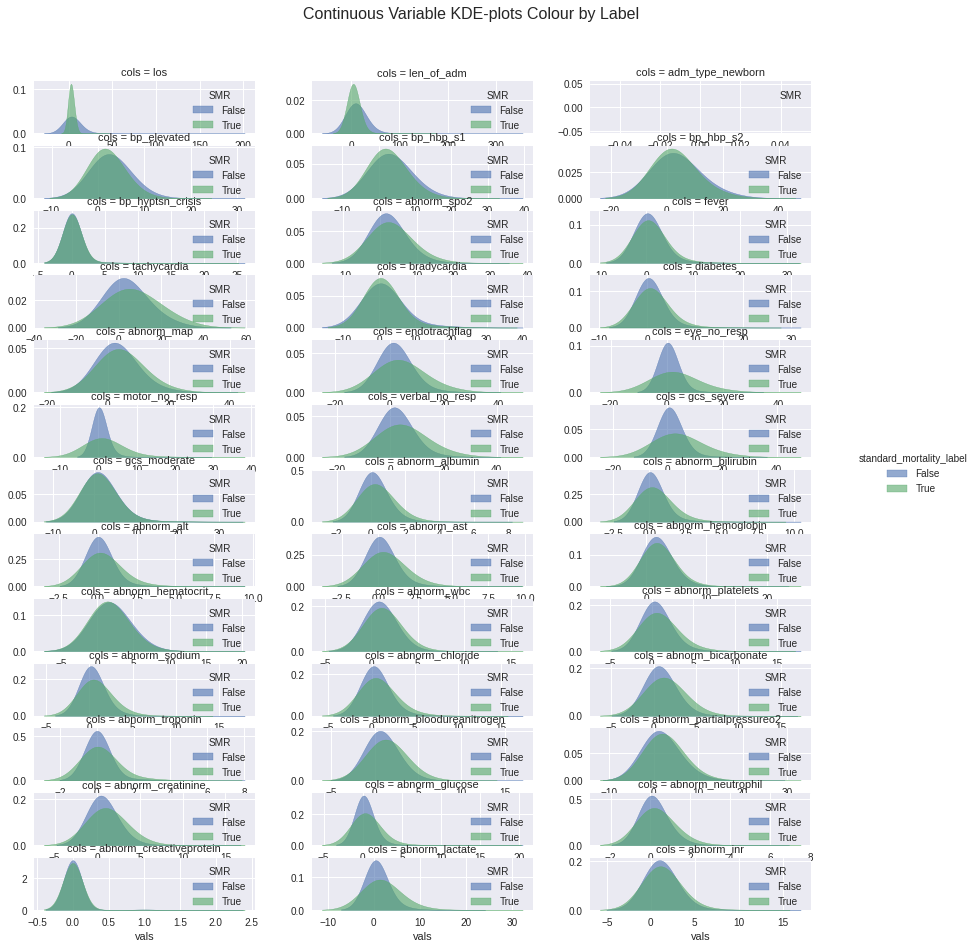

In [185]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
plt.suptitle('Bar Charts for Categorical Variables (colour by SMR Labels)', size=20)
for variable, subplot in zip(CATEGORICAL_4_VIZ, ax.flatten()):
    sns.countplot(x=variable,  hue='standard_mortality_label', data=df, ax=subplot)
plt.show()

df_mel = pd.melt(df[CONTINUOUS_4_VIZ], id_vars=['standard_mortality_label'],
                 var_name = 'cols',value_name= 'vals')
p = sns.FacetGrid(df_mel
                  , col = 'cols'
                  , hue = 'standard_mortality_label'
                  , col_wrap= 3
                  , sharex=False
                  , sharey=False
                  , margin_titles=True
                  , legend_out=True)
pg = (p.map(sns.kdeplot, "vals", alpha=0.6, shade=True, bw=1.5).add_legend())
#pg = p.map(plt.hist, 'vals', alpha = 0.6).add_legend()
pg.fig.suptitle('Continuous Variable KDE-plots Colour by Label', size=16)
pg.fig.subplots_adjust(top=.9)
pg.fig.set_size_inches(14,13)
for ax in pg.axes.ravel():
    ax.legend(title="SMR"
             , loc='upper right')
plt.show()

In [ ]:
# Pair Plot for Multi-collinearity Check
p = sns.PairGrid(df[CONTINUOUS_4_VIZ], hue = 'standard_mortality_label')
pg = p.map_diag(plt.hist, alpha = 0.8)
pg = pg.map_offdiag(plt.scatter, alpha = 0.5, s=5)
for ax in pg.axes.flatten():
    # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 90)
    # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')
pg = pg.add_legend()
pg.fig.suptitle('PairGrid Plot for Continuous Variables (colour by SMR)', size=20)
pg.fig.subplots_adjust(top=.9)
pg.fig.set_size_inches(14,13)
plt.show()

In [98]:
#X = df.drop(['ever_booked',''], axis=1) #feature set
X = df.drop(['standard_mortality_label'], axis=1) #feature set
y = df[['standard_mortality_label']] #target set

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, 
                                                    test_size = 0.2, stratify = y)

# Normalise feature for baseline model
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [100]:
# packages for model pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
# packages for model performance evaluation
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score # Area under PR curve
from sklearn.metrics import matthews_corrcoef # Matthews Correlation Coefficient <- for ranking only
from sklearn.metrics import cohen_kappa_score # Cohen's kappa
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import time
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve

# Transformer for pipeline
scaler = StandardScaler()

# Unbalanced dataset
average_precision_scorer = make_scorer(average_precision_score)
f1_scorer = make_scorer(f1_score)
cohens_kappa_scorer = make_scorer(cohen_kappa_score)
matthew_corrcoe_scorer = make_scorer(matthews_corrcoef)
scoring = {'AP': average_precision_scorer,
           'F1': f1_scorer, 
           'CK': cohens_kappa_scorer,
           'MC': matthew_corrcoe_scorer,}

In [101]:
def baseline_model_performance(dictionary_of_algos, X_train, y_train, X_test, y_test, labels):
    """passing list of algorithms to run and compare baseline performance
    also need to pass in training and test feature sets and target sets
    and list of labels for confusion matrix visualisation"""
    for key, classifier in dictionary_of_algos.items():
        start = time.time()
        classifier.fit(X_train, y_train)
        
        y_pred = classifier.predict(X_test)
        y_pred_proba = classifier.predict_proba(X_test)[:,1]
        end = time.time()
        used = end - start
        # Confusion Matrix
        cm = confusion_matrix(y_pred, y_test)
        # ROC True Positive Rate, False Positive Rate
        fpr, tpr, thresholds0 = roc_curve(y_test, y_pred_proba)
        # Precision and Recall
        precision, recall, thresholds1 = precision_recall_curve(y_test, y_pred_proba)
        # F1 Score
        f1 = f1_score(y_test, y_pred)
        # Accuracy
        accuracy = classifier.score(X_test_scaled, y_test)
        # ROC_AUC, PR_AUC
        roc_auc = auc(fpr, tpr)
        pr_auc = auc(recall, precision)
        print('\n')
        print('--------'+key+' Baseline Model---------')
        print('\n')
        # Print Baseline Results
        print("Job took: {}s".format(used))
        print("Baseline Model parameters:\n {}".format(classifier.get_params))
        print("Best cross-validation score (Accuracy): {:.4f}".format(classifier.score(X_test, y_test)))
        print('Accuracy: {0:.3f} \nF1-score: {1:.3f} \nPR_AUC: {2:.3f} \nROC_AUC: {3:.3f} \n'.
              format(accuracy, f1, pr_auc, roc_auc))
        
        # get importance
        if key=='Logistic Regression':
            importance = classifier.coef_[0]
        else:
            importance = classifier.feature_importances_
        # summarize feature importance
        cols = X.columns.values
        df_importance = pd.DataFrame({'feature':cols, 'importance':importance})
        important_10 = df_importance.nlargest(15, 'importance').sort_values(by='importance', ascending=False)
        print(important_10)
        
        print(classification_report(y_test, y_pred))
        print('\n')
        BIG_SIZE=22
        plt.style.use('seaborn')
        #plt.rcParams.update({'font.size': 22})
        #fig = plt.figure(figsize=(23, 28))
        #ax = fig.add_subplot(2, 1, 1)
        fig, ax = plt.subplots(2,2,figsize=(35, 23))
        #ax = ax.flatten()
        sns.heatmap(cm, annot=True, fmt='.0f', ax=ax[0,0],
                    cmap="Dark2", norm=colors.PowerNorm(gamma=0.5),
                    annot_kws={"size": 18})
        ax[0,0].set_xlabel('Predicted', fontsize=BIG_SIZE);
        ax[0,0].set_ylabel('Actual', fontsize=BIG_SIZE); 
        ax[0,0].set_title('Confusion Matrix', fontsize=BIG_SIZE); 
        ax[0,0].xaxis.set_ticklabels(labels); 
        ax[0,0].yaxis.set_ticklabels(labels);
        ax[0,0].tick_params(labelsize=BIG_SIZE)
        
        ax[0,1].barh("feature", "importance",data=important_10)
        ax[0,1].set_xlabel('Features', fontsize=BIG_SIZE);
        ax[0,1].set_ylabel('Importance', fontsize=BIG_SIZE);
        ax[0,1].set_title('Feature Importance', fontsize=BIG_SIZE); 
        ax[0,1].tick_params(labelsize=BIG_SIZE)
        
        ax[1,0].plot(fpr, tpr, marker='.', label=key)
        ax[1,0].plot([0, 1], [0, 1], linestyle='--', label='No Skill')
        ax[1,0].set_xlabel('False Positive Rate (FPR)', fontsize=BIG_SIZE);
        ax[1,0].set_ylabel('True Positive Rate (TPR)', fontsize=BIG_SIZE);
        ax[1,0].set_title('ROC Curve', fontsize=BIG_SIZE)
        ax[1,0].tick_params(labelsize=BIG_SIZE)
        
        ax[1,1].plot(recall, precision, marker='.', label=key)
        no_skill = len(y[y==True]) / len(y)
        ax[1,1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
        ax[1,1].set_xlabel('Recall', fontsize=BIG_SIZE);
        ax[1,1].set_ylabel('Precision', fontsize=BIG_SIZE);
        ax[1,1].set_title('PR Curve', fontsize=BIG_SIZE)
        ax[1,1].tick_params(labelsize=BIG_SIZE)
        #plot_precision_recall_curve(classifier, X_test, y_test)
        #plot_roc_curve(classifier, X_test, y_test)
        plt.show()



--------Logistic Regression Baseline Model---------


Job took: 0.4951188564300537s
Baseline Model parameters:
 <bound method BaseEstimator.get_params of LogisticRegression(n_jobs=-1, random_state=0, solver='liblinear')>
Best cross-validation score (Accuracy): 0.9450
Accuracy: 0.945 
F1-score: 0.471 
PR_AUC: 0.578 
ROC_AUC: 0.880 

                     feature  importance
39                gcs_severe      0.7963
31               tachycardia      0.4520
59            abnorm_lactate      0.3809
48          abnorm_platelets      0.3130
5            age_bins_over80      0.2910
40              gcs_moderate      0.2823
34                abnorm_map      0.2478
29               abnorm_spo2      0.2344
22        adm_type_emergency      0.2031
55         abnorm_creatinine      0.1903
37             motor_no_resp      0.1858
54  abnorm_partialpressureo2      0.1804
42          abnorm_bilirubin      0.1736
4             age_bins_60-80      0.1650
47                abnorm_wbc      0.1564
        

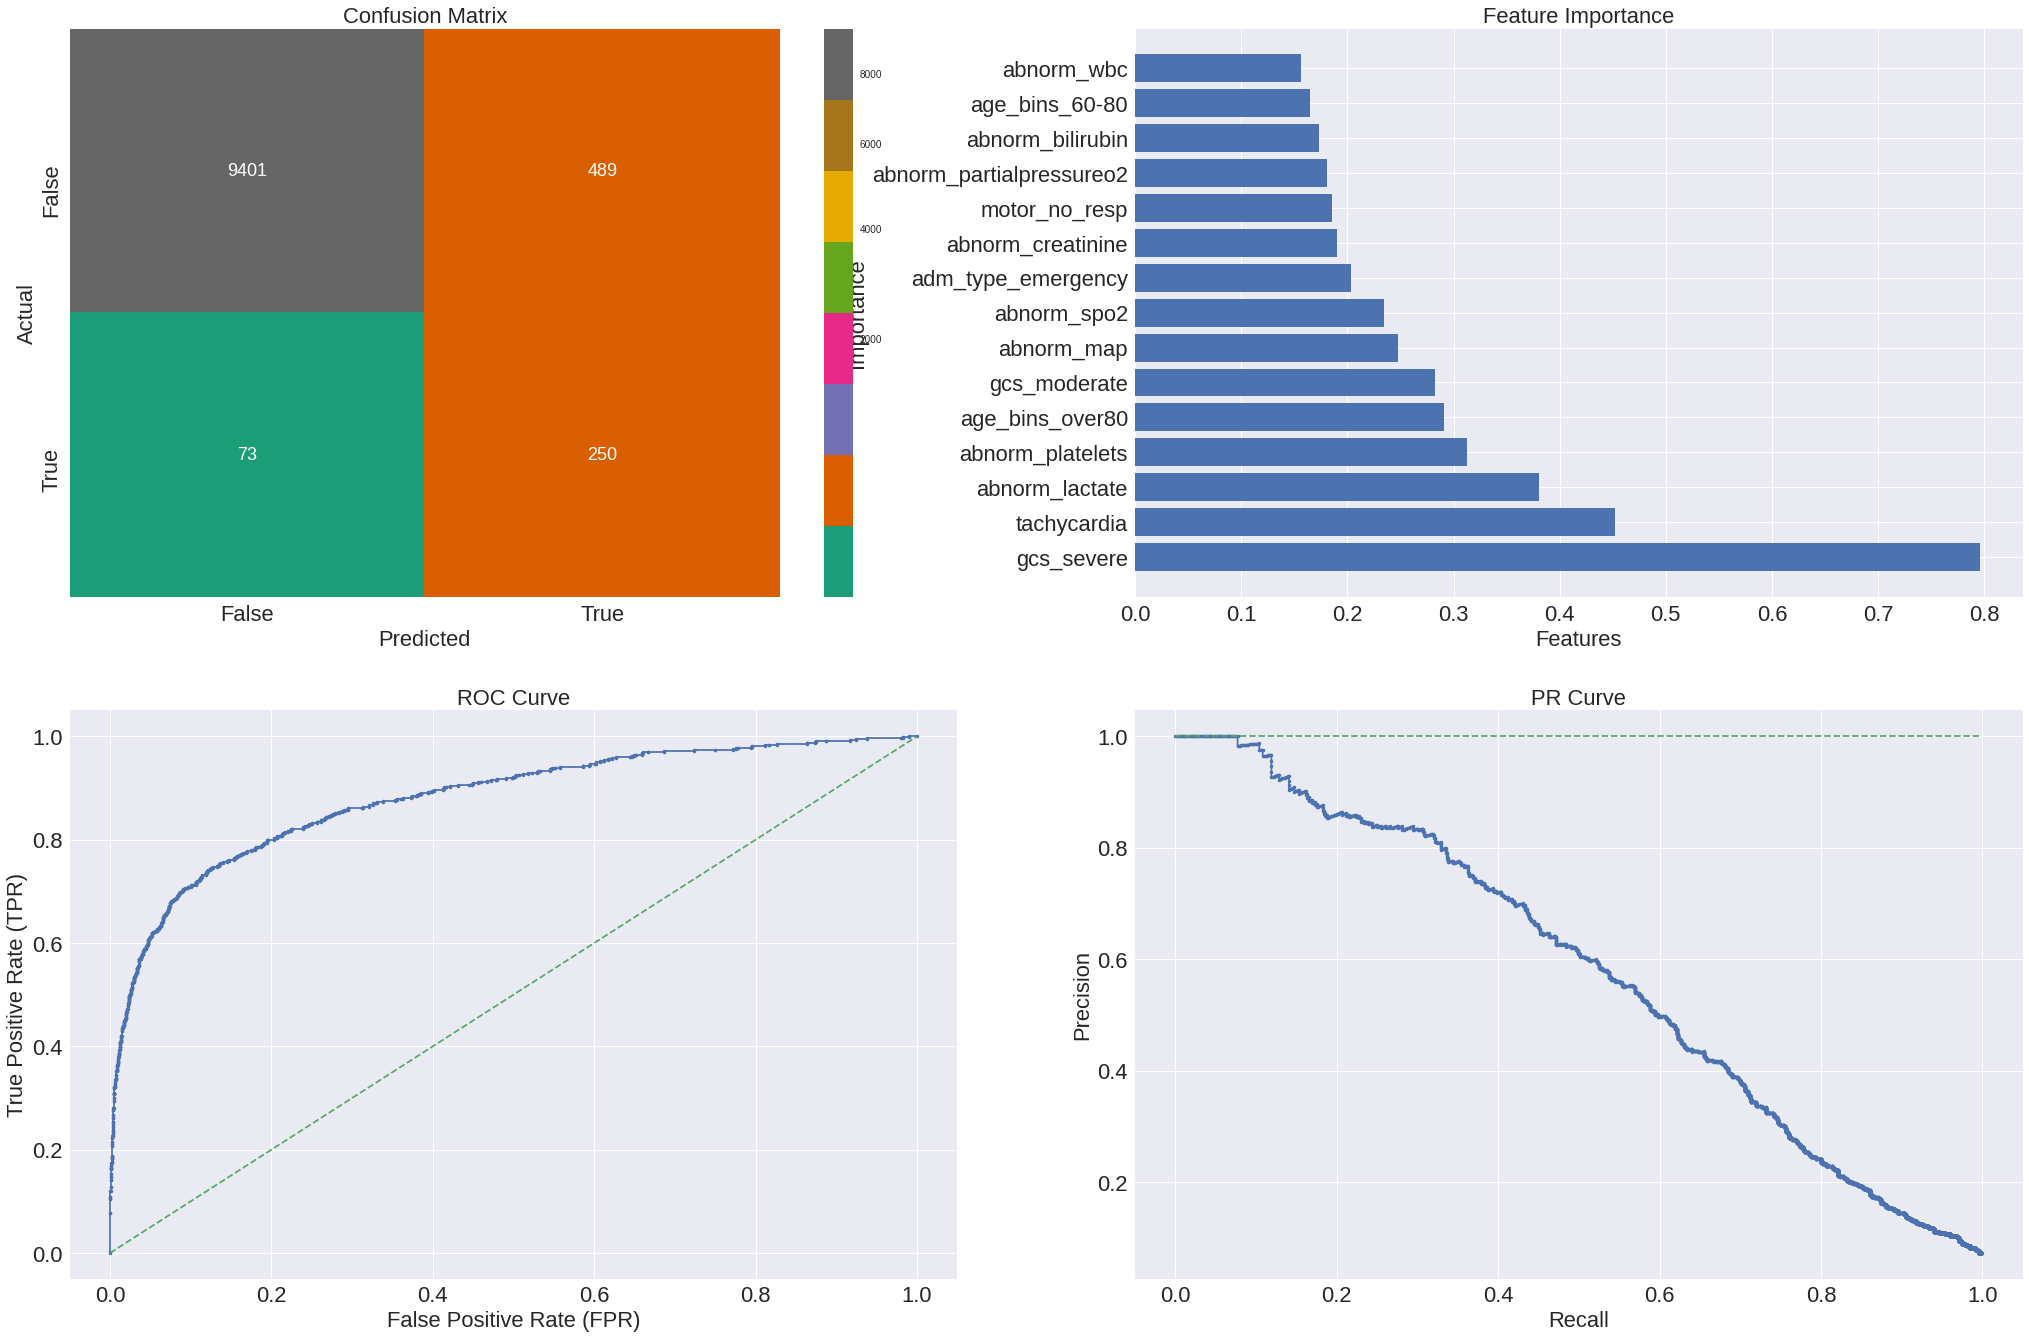



--------Random Forest Baseline Model---------


Job took: 0.5486049652099609s
Baseline Model parameters:
 <bound method BaseEstimator.get_params of RandomForestClassifier(class_weight={0: 87, 1: 12}, n_jobs=-1, random_state=0)>
Best cross-validation score (Accuracy): 0.9521
Accuracy: 0.952 
F1-score: 0.525 
PR_AUC: 0.675 
ROC_AUC: 0.910 

                     feature  importance
13                len_of_adm      0.1329
0                        los      0.0964
29               abnorm_spo2      0.0365
34                abnorm_map      0.0343
31               tachycardia      0.0318
36               eye_no_resp      0.0282
39                gcs_severe      0.0281
54  abnorm_partialpressureo2      0.0277
59            abnorm_lactate      0.0276
26                 bp_hbp_s1      0.0260
25               bp_elevated      0.0253
37             motor_no_resp      0.0239
40              gcs_moderate      0.0236
27                 bp_hbp_s2      0.0229
38            verbal_no_resp      0.0228
 

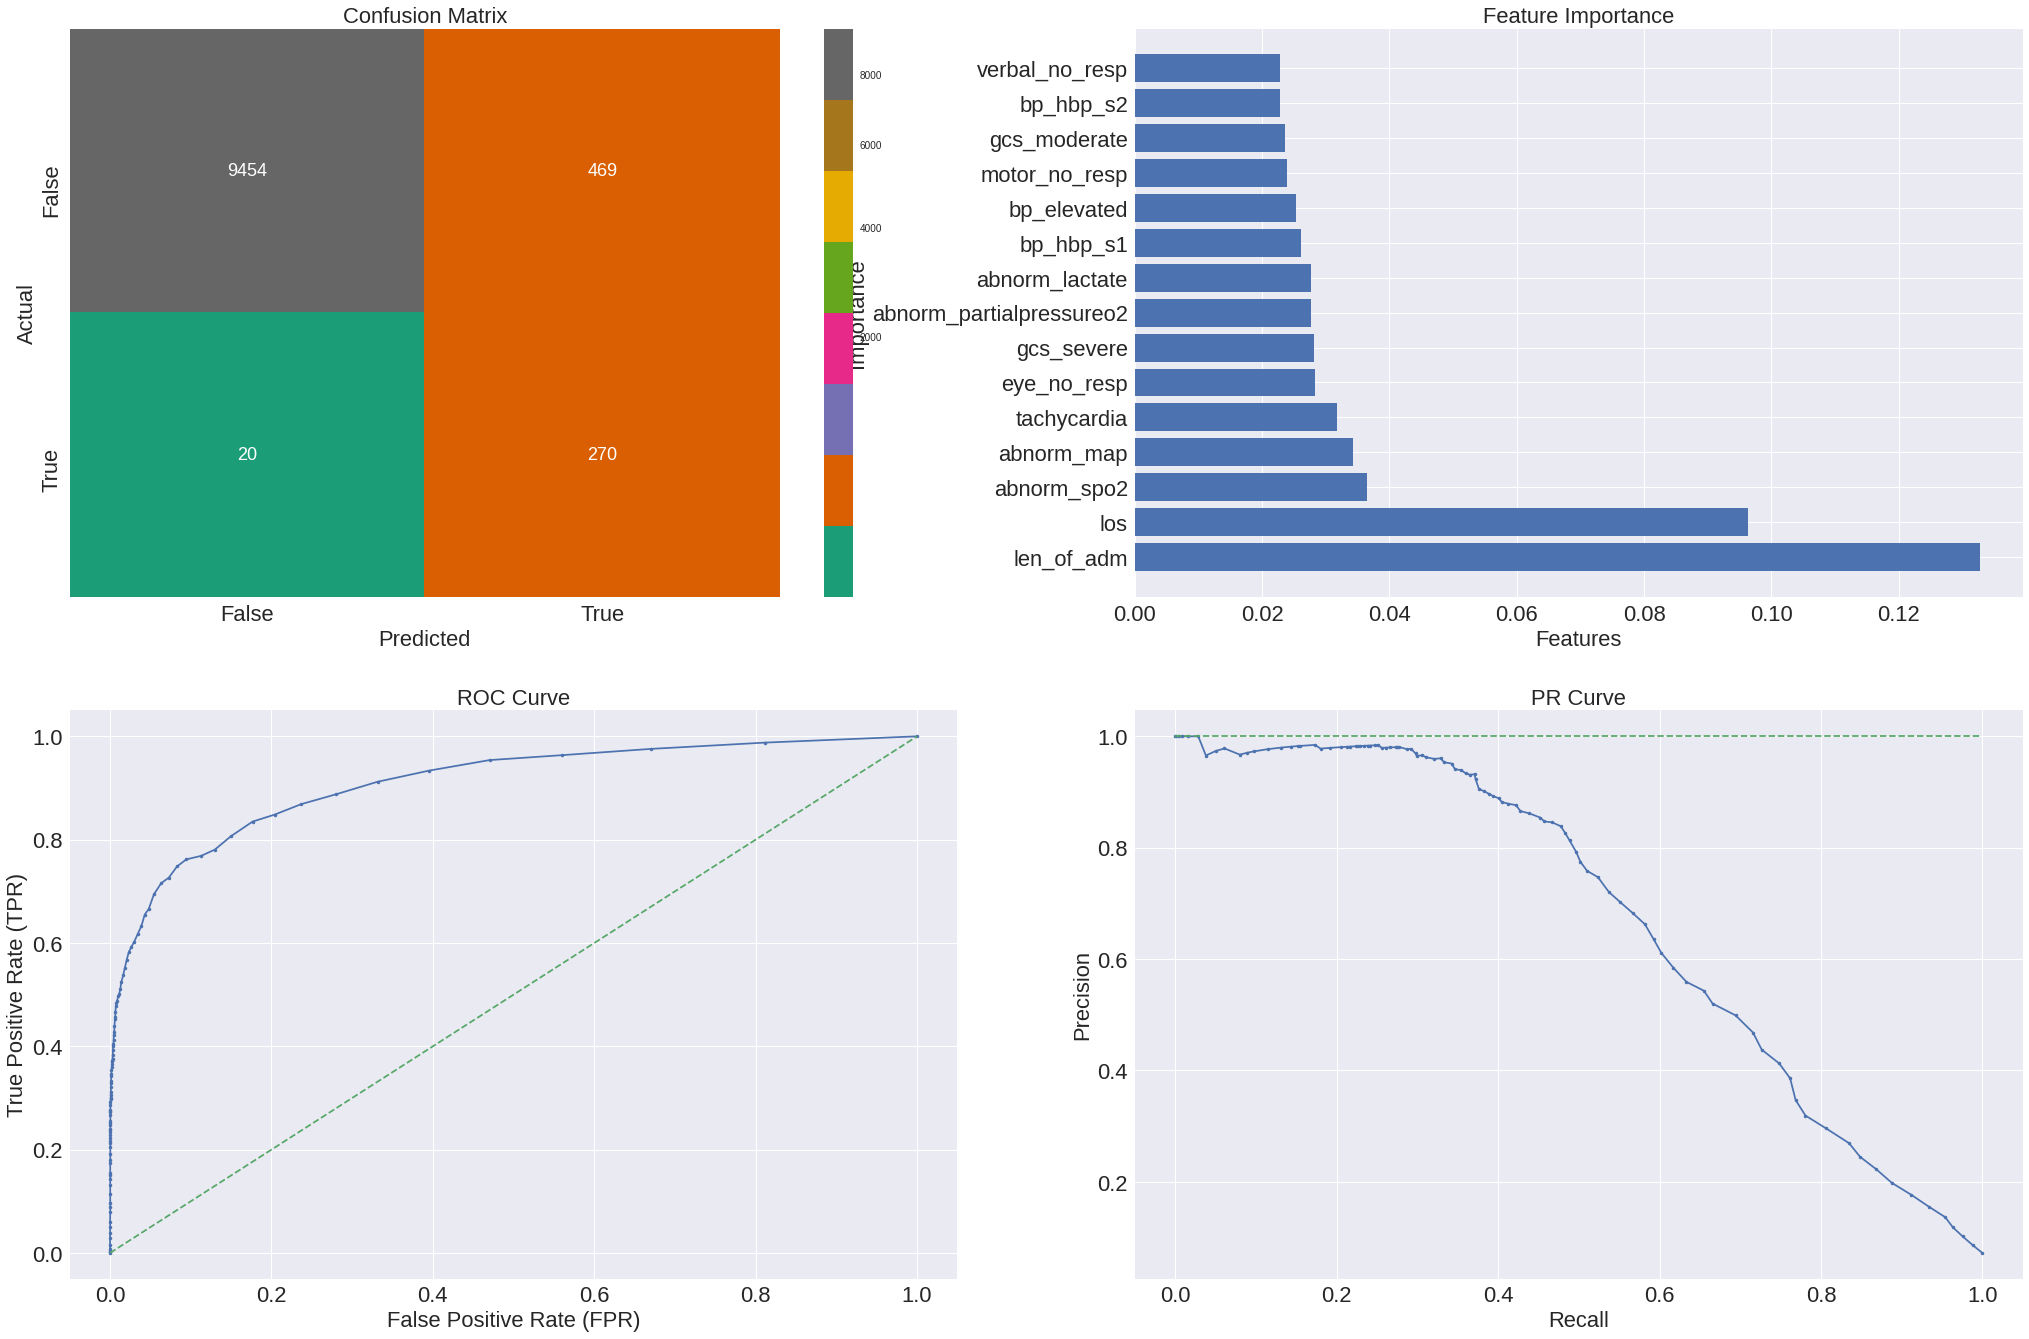



--------Gradient Boosted Tree Baseline Model---------


Job took: 6.6635847091674805s
Baseline Model parameters:
 <bound method BaseEstimator.get_params of GradientBoostingClassifier(random_state=0)>
Best cross-validation score (Accuracy): 0.9571
Accuracy: 0.957 
F1-score: 0.614 
PR_AUC: 0.722 
ROC_AUC: 0.933 

                     feature  importance
13                len_of_adm      0.3767
39                gcs_severe      0.2088
0                        los      0.1154
59            abnorm_lactate      0.0545
54  abnorm_partialpressureo2      0.0419
36               eye_no_resp      0.0276
31               tachycardia      0.0264
53  abnorm_bloodureanitrogen      0.0168
55         abnorm_creatinine      0.0150
5            age_bins_over80      0.0125
2             age_bins_20-40      0.0111
40              gcs_moderate      0.0103
42          abnorm_bilirubin      0.0093
29               abnorm_spo2      0.0073
25               bp_elevated      0.0066
              precision    re

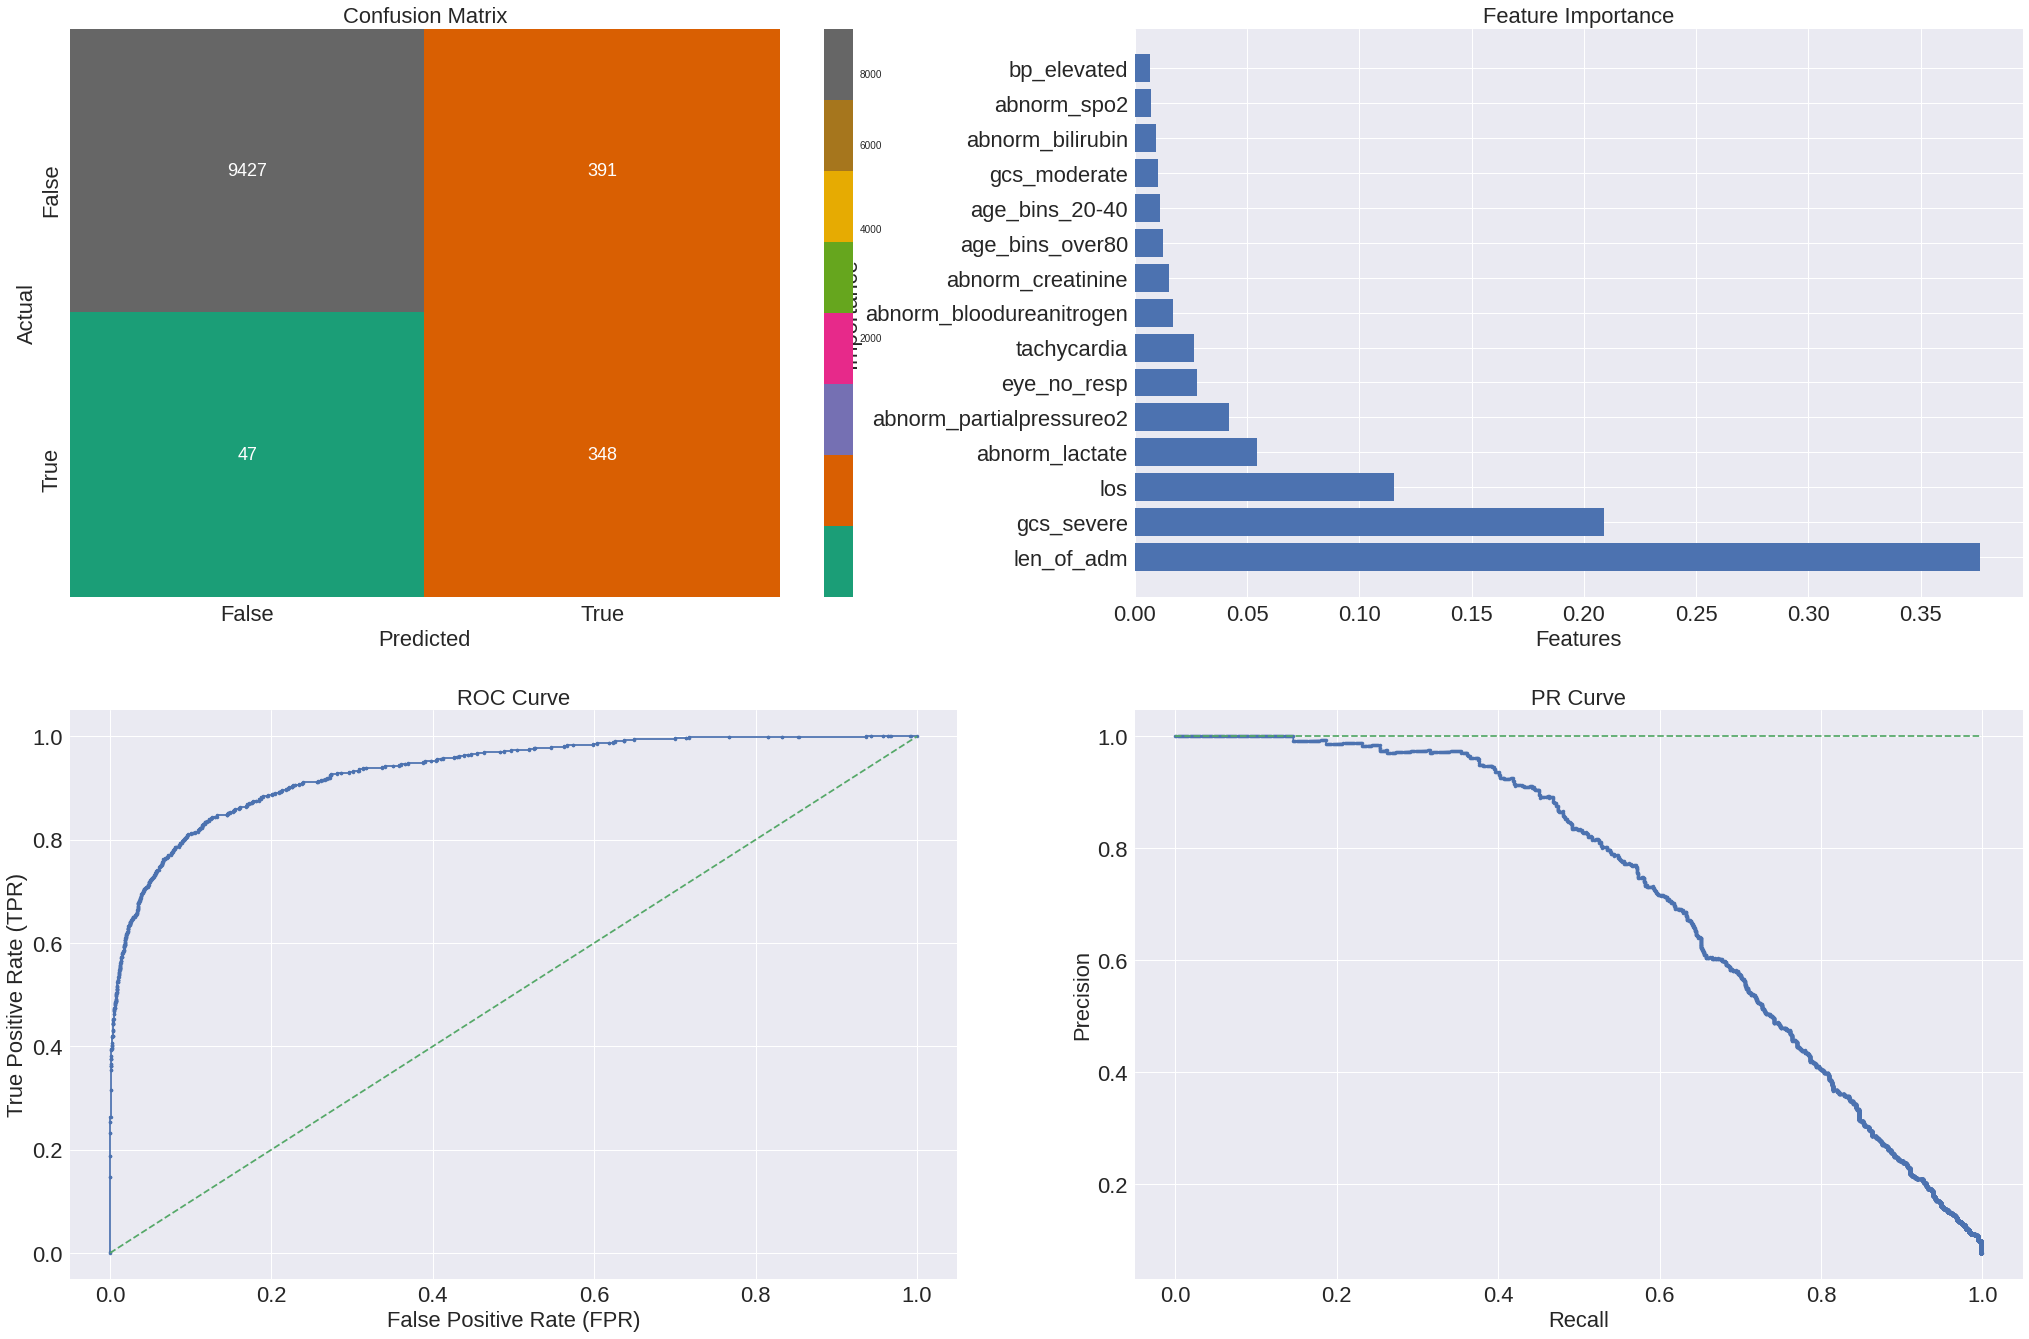



--------XG Boost Baseline Model---------


Job took: 0.21761727333068848s
Baseline Model parameters:
 <bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_metric=['error', 'map', 'aucpr'], gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)>
Best cross-validation score (Accuracy): 0.9576
Accuracy: 0.958 
F1-score: 0.675 
PR_AUC: 0.756 
ROC_AUC: 0.946 

                     feature  importance
39                gcs_severe      0.0954
13                len_of_adm     

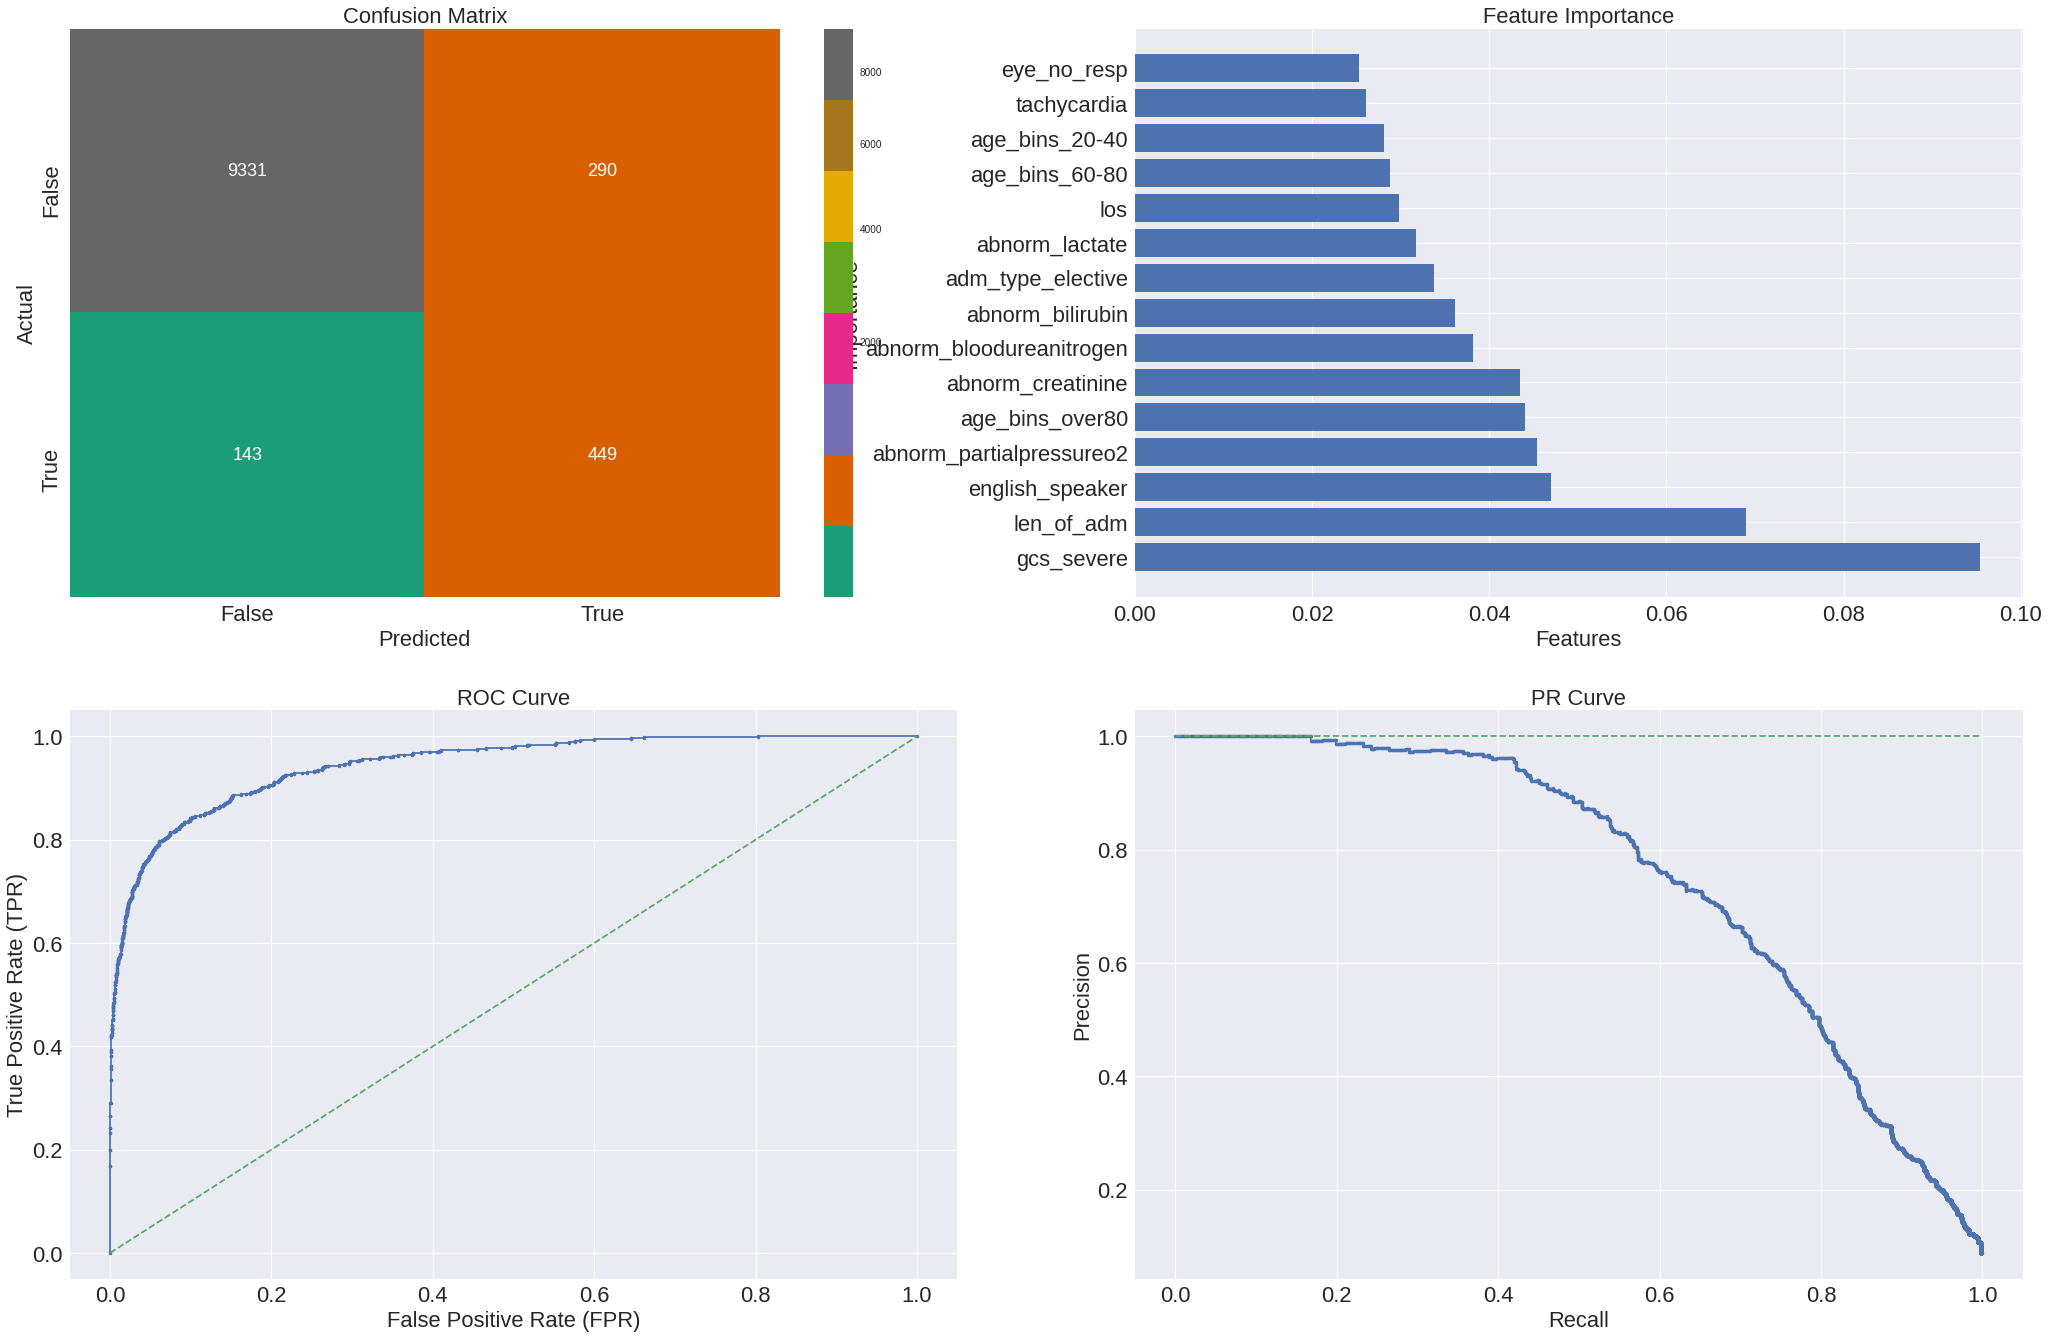

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.colors as colors
from xgboost import XGBClassifier

RFC = RandomForestClassifier(random_state=0, n_jobs=-1, class_weight={0:87, 1:12})
LR = LogisticRegression(random_state=0, solver='liblinear', n_jobs=-1)
#SVC = SVC(random_state=0, gamma='scale', probability=True)
GBC = GradientBoostingClassifier(random_state=0)
XGB = XGBClassifier(booster='gbtree', tree_method='gpu_hist', objective='binary:logistic',
                    eval_metric=['error','map','aucpr'], 
                    subsample=1, scale_pos_weight=2, max_depth=4,learning_rate=0.3,
#                     verbosity=0, gamma = 0.2, max_depth=6, min_child_weight=9,
#                     scale_pos_weight=9, n_estimators=1000, subsample=0.8, learning_rate=0.1,
#                     colsample_bytree=0.8, 
                   ) 
#param set after tuning
algo_dict = {'Logistic Regression': LR,
             'Random Forest': RFC,
             'Gradient Boosted Tree': GBC,
             'XG Boost': XGB,}
labels = ['False', 'True']  

# compare your results        
baseline_model_performance(algo_dict, X_train_scaled, y_train, X_test_scaled, y_test, labels)

In [142]:
from sklearn.model_selection import GridSearchCV

def tuning_models_GSCV(X_train, y_train, X_test, y_test, labels, nested_dict_of_models_params, scaler, scoring, refit_measure='F1'):
    """"""
    models = []
    time_used = []
    best_cv_scores = []
    roc_test_set = []
    pr_test_set = []
    f1_test_set = []
    ap_test_set = []
    mc_test_set = []
    ck_test_set = []
    acc_test_set = []
    fpr_test_set = []
    tpr_test_set = []
    precision_test_set = []
    recall_test_set = []
    tn_count = []
    fp_count = []
    fn_count = []
    tp_count = []
    tuned_models = []
    
    for model, details in nested_dict_of_models_params.items():
        models.append(model)
        clf = details['clf']
        params = details['params']        
        
        pipeline = Pipeline([('Transformer', scaler), ('Estimator', clf)])
        
        start = time.time()
        # Repeated Stratified K-Fold Cross-Validation set:
        cv = StratifiedShuffleSplit(n_splits=7, test_size=0.3, random_state=0)
        grid = GridSearchCV(pipeline, params,
                            cv=cv, n_jobs=-1, scoring=scoring, refit='F1')
        
        grid.fit(X_train, y_train)
        y_pred = grid.predict(X_test) #model prediction
        y_pred_proba = grid.predict_proba(X_test)[:,1] #prediction probability
        end = time.time()
        used = end - start #time the computation
        tuned_models.append(grid)
        time_used.append(used)
        best_cv_scores.append(grid.best_score_)

        # For Visualisation - Confusion Matrix
        cm = confusion_matrix(y_pred, y_test)
        tn, fp, fn, tp = cm.ravel()
        tn_count.append(tn)
        fp_count.append(fp)
        fn_count.append(fn)
        tp_count.append(tp)

        # For Visualisation - ROC, False Positive Rate, True Positive Rate
        fpr, tpr, thresholds0 = roc_curve(y_test, y_pred_proba)
        fpr_test_set.append(fpr)
        tpr_test_set.append(tpr)

        # For Visualisation - Precision, Recall
        precision, recall, thresholds1 = precision_recall_curve(y_test, y_pred_proba)
        precision_test_set.append(precision)
        recall_test_set.append(recall)
        
        f1 = f1_score(y_test, y_pred)
        ap = average_precision_score(y_test, y_pred_proba)
        mc = matthews_corrcoef(y_test, y_pred)
        ck = cohen_kappa_score(y_test, y_pred)
        f1_test_set.append(f1)
        ap_test_set.append(ap)
        mc_test_set.append(mc)
        ck_test_set.append(ck)

        # ROC_AUC, PR_AUC
        roc_auc = auc(fpr, tpr)
        pr_auc = auc(recall, precision)
        accuracy = (tn + tp)/(tn + fp + tp + fn)
        acc_test_set.append(accuracy)
        roc_test_set.append(roc_auc)
        pr_test_set.append(pr_auc)
       # get importance
        if model=='Logistic Regression':
            importance = \
            grid.best_estimator_.named_steps["Estimator"].coef_[0]
        else:
            importance = \
            grid.best_estimator_.named_steps["Estimator"].feature_importances_
        # summarize feature importance
        cols = X.columns.values
        df_importance = pd.DataFrame({'feature':cols, 'importance':importance})
        important_10 = df_importance.nlargest(15, 'importance').\
                            sort_values(by='importance', ascending=False)
        
        print('\n')
        print('--------', model,'Tuned Model---------')
        print('\n')
        # Print Grid Search CV Results
        print("Job took: {}s".format(used))
        print("Set of parameters from Exhaustive Grid Search CV:\n {}".format(grid.get_params))
        print("Best parameters from Grid Search CV:\n {}".format(grid.best_params_))
        print("Best cross-validation score: {:.4f}".format(grid.best_score_))
        print(cm)
        print("Accuracy: {:.4f}".format((tp+tn)/(tp+tn+fp+fn)))
        print("Recall (FN): {:.4f}".format((tp)/(tp+fn)))
        print("Precision (FP): {:.4f}".format((tp)/(tp+fp)))
        print('F1-score: {0:.3f} \nPR_AUC: {1:.3f} \nROC_AUC: {2:.3f} \n'.
              format(f1, pr_auc, roc_auc))
        print(classification_report(y_test, y_pred))
        print('---------------------------------------\n')
        print(important_10)

        BIG_SIZE=22
        plt.style.use('seaborn')
        fig, ax = plt.subplots(2,1,figsize=(35, 23))
        ax = ax.flatten()
        sns.heatmap(cm, annot=True, fmt='.0f', ax=ax[0],
                    cmap="Dark2", norm=colors.PowerNorm(gamma=0.5),
                    annot_kws={"size": 18})
        ax[0].set_xlabel('Predicted', fontsize=BIG_SIZE);
        ax[0].set_ylabel('Actual', fontsize=BIG_SIZE); 
        ax[0].set_title('Confusion Matrix', fontsize=BIG_SIZE); 
        ax[0].xaxis.set_ticklabels(labels); 
        ax[0].yaxis.set_ticklabels(labels);
        ax[0].tick_params(labelsize=BIG_SIZE)
        
        ax[1].barh("feature", "importance",data=important_10)
        ax[1].set_xlabel('Features', fontsize=BIG_SIZE);
        ax[1].set_ylabel('Importance', fontsize=BIG_SIZE);
        ax[1].set_title('Feature Importance', fontsize=BIG_SIZE); 
        ax[1].tick_params(labelsize=BIG_SIZE)
        #plot_precision_recall_curve(classifier, X_test, y_test)
        #plot_roc_curve(classifier, X_test, y_test)
        plt.show()
    return tuned_models, models, time_used, best_cv_scores, \
            roc_test_set, pr_test_set, f1_test_set, ap_test_set, \
            mc_test_set, ck_test_set, acc_test_set, tn_count, fp_count,\
            fn_count, tp_count, fpr_test_set, tpr_test_set, precision_test_set, recall_test_set

In [143]:
def tuning_models_RSCV(X_train, y_train, X_test, y_test, labels, nested_dict_of_models_params, scaler, scoring, refit_measure='F1'):
    """"""
    models = []
    time_used = []
    best_cv_scores = []
    roc_test_set = []
    pr_test_set = []
    f1_test_set = []
    ap_test_set = []
    mc_test_set = []
    ck_test_set = []
    acc_test_set = []
    tn_count = []
    fp_count = []
    fn_count = []
    tp_count = []
    tuned_models = []
    
    for model, details in nested_dict_of_models_params.items():
        models.append(model)
        clf = details['clf']
        params = details['params']        
        
        pipeline = Pipeline([('Transformer', scaler), ('Estimator', clf)])

        start = time.time()
        # Repeated Stratified K-Fold Cross-Validation set:
        cv = StratifiedShuffleSplit(n_splits=15, test_size=0.25, random_state=0)
        grid = RandomizedSearchCV(pipeline, params, cv=cv, n_jobs=-1, scoring=scoring, refit=refit_measure)
        grid.fit(X_train, y_train)
        y_pred = grid.predict(X_test) #model prediction
        y_pred_proba = grid.predict_proba(X_test)[:,1] #prediction probability
        end = time.time()
        used = end - start #time the computation
        tuned_models.append(grid)
        time_used.append(used)
        best_cv_scores.append(grid.best_score_)

        # For Visualisation - Confusion Matrix
        cm = confusion_matrix(y_pred, y_test)
        tn, fp, fn, tp = cm.ravel()
        tn_count.append(tn)
        fp_count.append(fp)
        fn_count.append(fn)
        tp_count.append(tp)

        # For Visualisation - ROC, False Positive Rate, True Positive Rate
        fpr, tpr, thresholds0 = roc_curve(y_test, y_pred_proba)

        # For Visualisation - Precision, Recall
        precision, recall, thresholds1 = precision_recall_curve(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)
        ap = average_precision_score(y_test, y_pred_proba)
        mc = matthews_corrcoef(y_test, y_pred)
        ck = cohen_kappa_score(y_test, y_pred)
        f1_test_set.append(f1)
        ap_test_set.append(ap)
        mc_test_set.append(mc)
        ck_test_set.append(ck)

        # ROC_AUC, PR_AUC
        roc_auc = auc(fpr, tpr)
        pr_auc = auc(recall, precision)
        accuracy = (tn + tp)/(tn + fp + tp + fn)
        acc_test_set.append(accuracy)
        roc_test_set.append(roc_auc)
        pr_test_set.append(pr_auc)
        
        print('\n')
        print('--------', model,'Tuned Model---------')
        print('\n')
        # Print Grid Search CV Results
        print("Job took: {}s".format(used))
        print("Set of parameters from Randomised Search CV:\n {}".format(grid.get_params))
        print("Best parameters from Grid Search CV:\n {}".format(grid.best_params_))
        print("Best cross-validation score: {:.4f}".format(grid.best_score_))
        print(cm)
        print("Accuracy: {:.4f}".format((tp+tn)/(tp+tn+fp+fn)))
        print("Recall (FN): {:.4f}".format((tp)/(tp+fn)))
        print("Precision (FP): {:.4f}".format((tp)/(tp+fp)))
        print('F1-score: {0:.3f} \nPR_AUC: {1:.3f} \nROC_AUC: {2:.3f} \n'.
              format(f1, pr_auc, roc_auc))
        print(classification_report(y_test, y_pred))
        print('---------------------------------------\n')
        #fig = plt.figure()
        #ax = fig.add_subplot(1, 1, 1)
        #sns.heatmap(cm, annot=True, fmt='.0f', ax=ax,
        #            cmap="Dark2", norm=colors.PowerNorm(gamma=0.5)
        #            , annot_kws={"size": 14})
        #ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
        #ax.set_title(model+'Confusion Matrix', fontsize=14); 
        #ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
        #plt.show()
    return tuned_models, models, time_used, best_cv_scores, \
            roc_test_set, pr_test_set, f1_test_set, ap_test_set, \
            mc_test_set, ck_test_set, acc_test_set, tn_count, fp_count, fn_count, tp_count

In [144]:
### Close
from collections import Counter
counter = Counter(y.standard_mortality_label.values)
estimate = counter[0] / counter[1]
#print('Estimate: %.3f' % estimate)
#100/estimate



-------- Logistic Regression Tuned Model---------


Job took: 23.6416437625885s
Set of parameters from Exhaustive Grid Search CV:
 <bound method BaseEstimator.get_params of GridSearchCV(cv=StratifiedShuffleSplit(n_splits=7, random_state=0, test_size=0.3,
            train_size=None),
             estimator=Pipeline(steps=[('Transformer', StandardScaler()),
                                       ('Estimator',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=0,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'Estimator__C': [0.01, 0.1, 1, 10, 100],
                         'Estimator__penalty': ['l1', 'l2']},
             refit='F1',
             scoring={'AP': make_scorer(average_precision_score),
                      'CK': make_scorer(cohen_kappa_score),
                      'F1': make_scorer(f1_score),
    

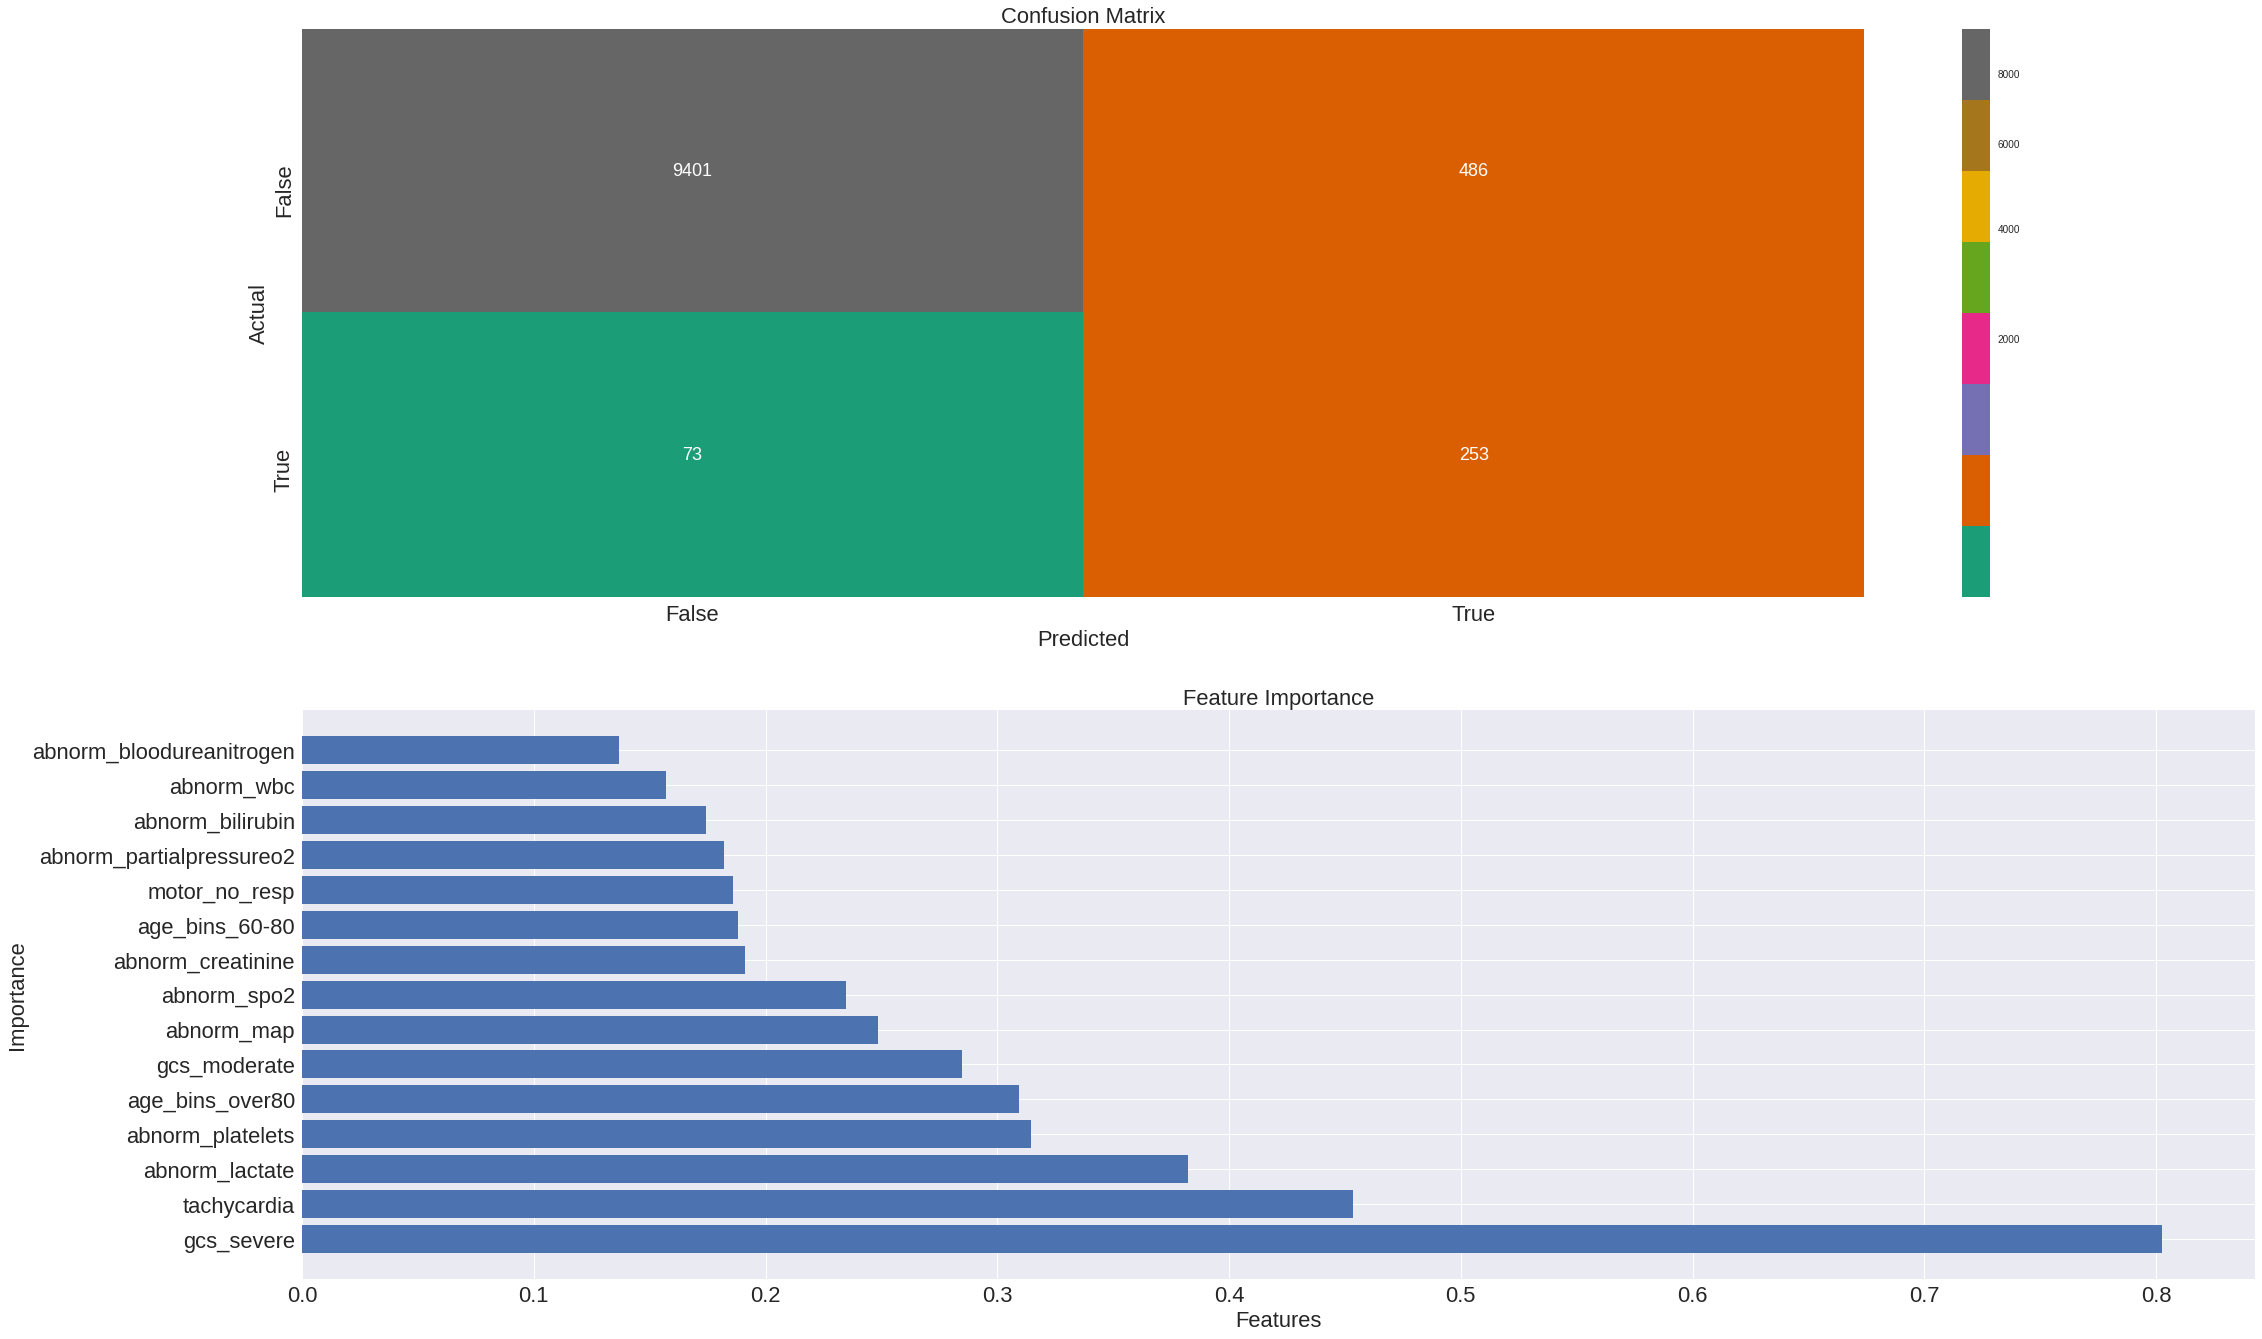



-------- Random Forest Tuned Model---------


Job took: 17.636741161346436s
Set of parameters from Exhaustive Grid Search CV:
 <bound method BaseEstimator.get_params of GridSearchCV(cv=StratifiedShuffleSplit(n_splits=7, random_state=0, test_size=0.3,
            train_size=None),
             estimator=Pipeline(steps=[('Transformer', StandardScaler()),
                                       ('Estimator',
                                        RandomForestClassifier(class_weight={0: 87,
                                                                             1: 12},
                                                               n_jobs=-1,
                                                               random_state=0))]),
             n_jobs=-1,
             param_grid={'Estimator__max_depth': [10, 20, 30],
                         'Estimator__n_estimators': [50, 80, 100]},
             refit='F1',
             scoring={'AP': make_scorer(average_precision_score),
                  

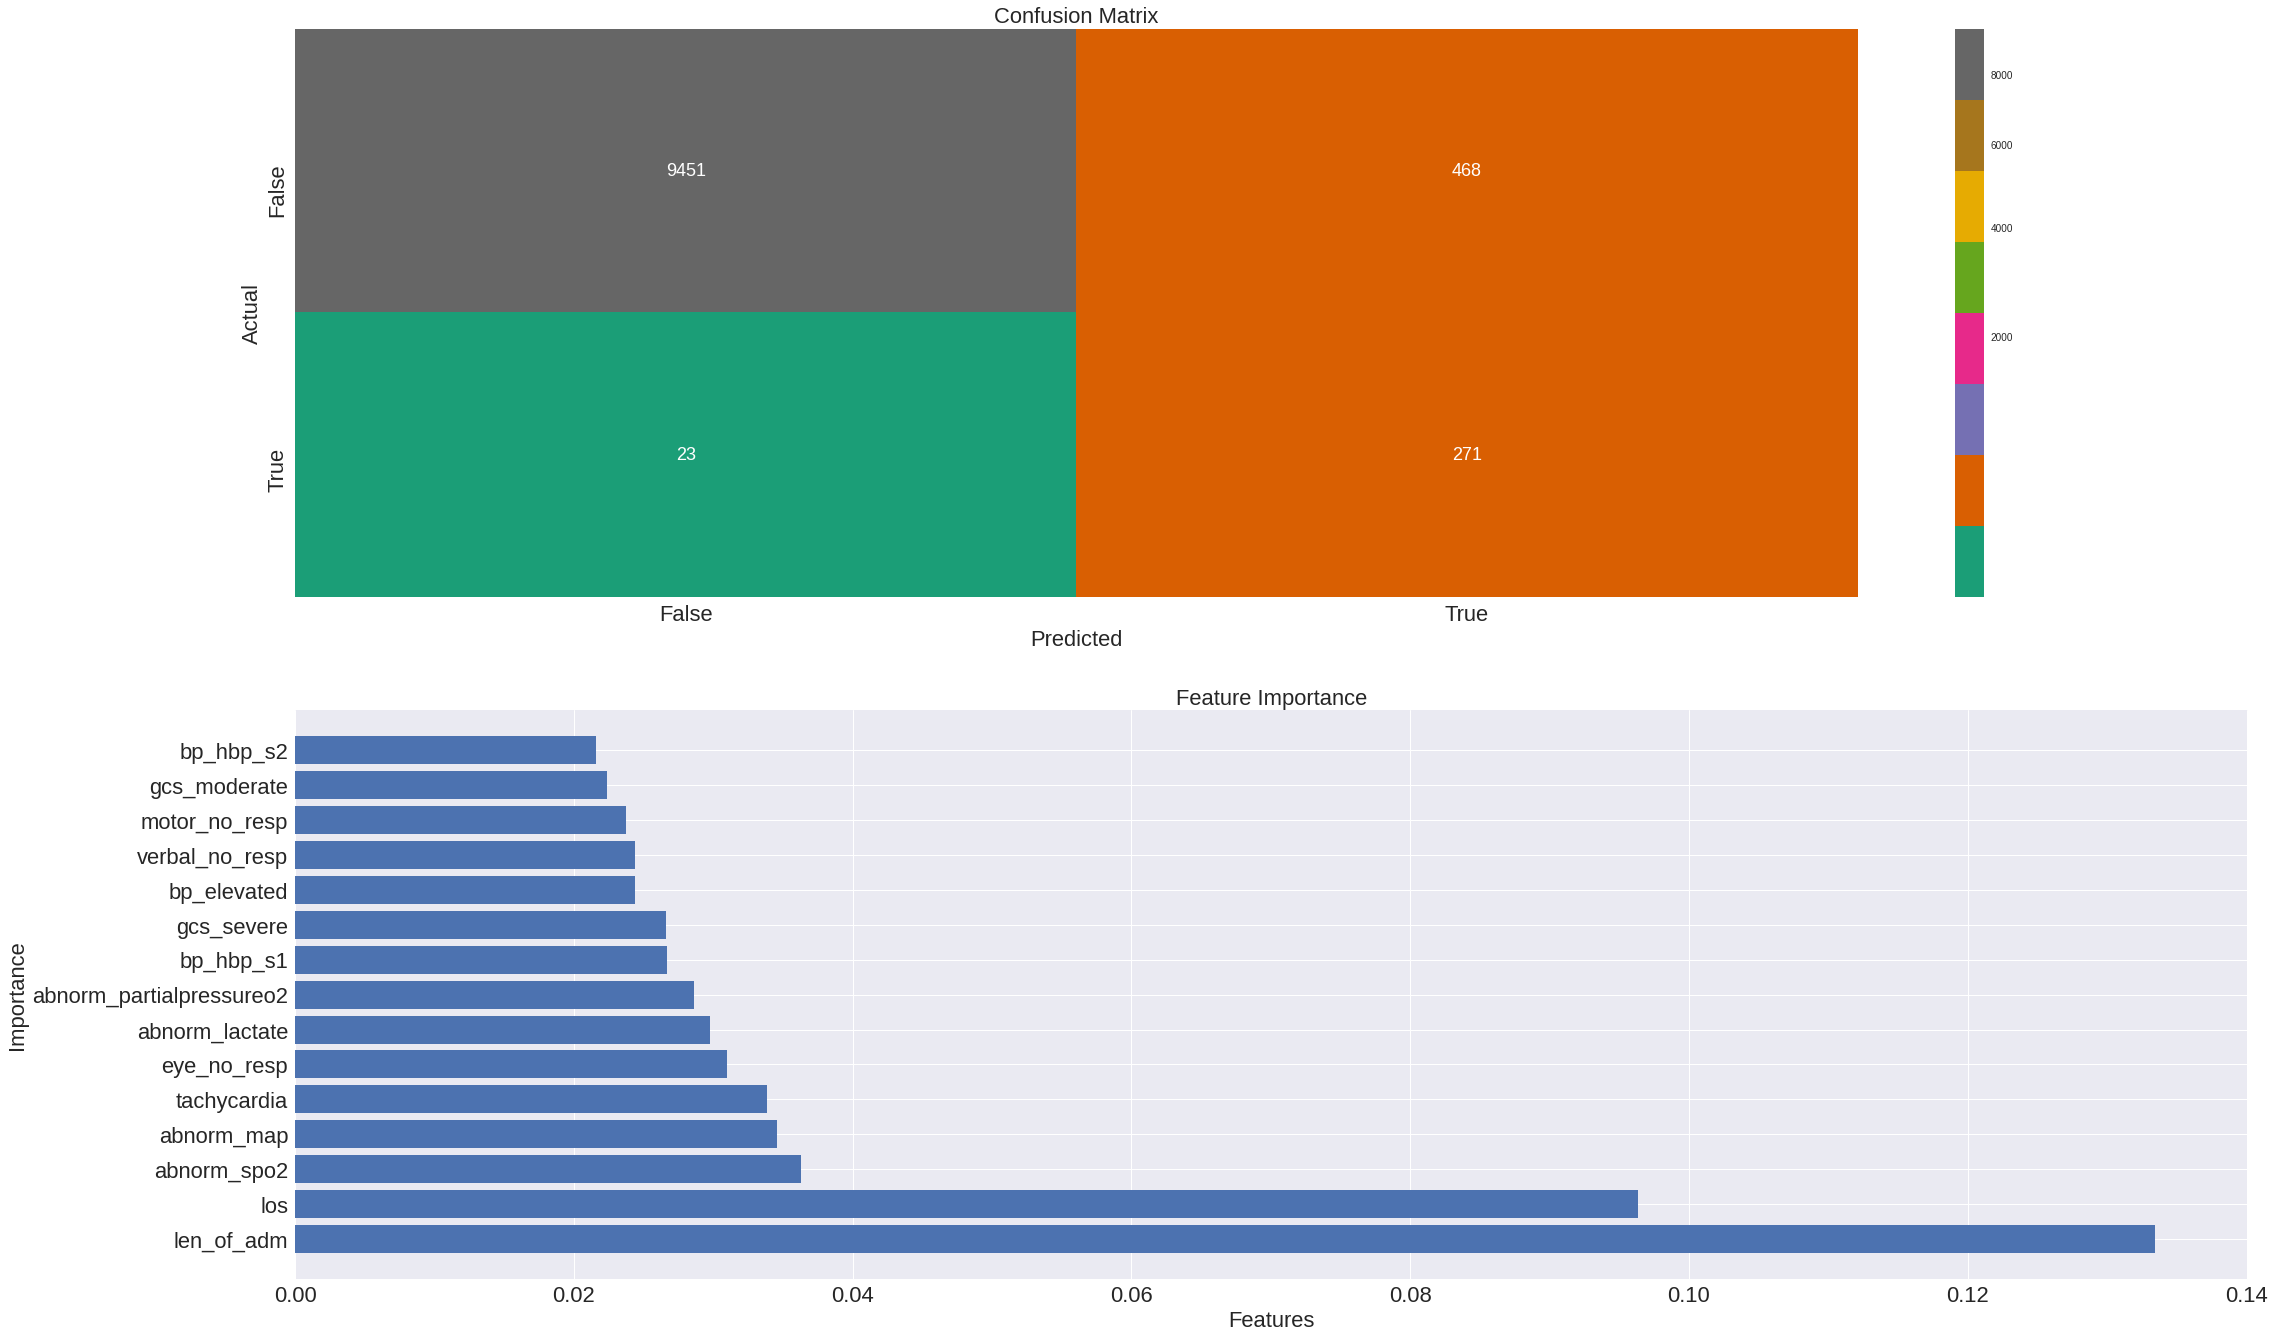

In [145]:
# Setting params for grid search CV
#Logistic Regression
param_grid_lg = {
    'Estimator__C': [ 0.01, 0.1, 1, 10, 100],
    #'Estimator__class_weight': [{1:w, 0:1-w} for w in np.linspace(0,1,16)],   
    'Estimator__penalty':['l1', 'l2'],
}
#Random Forest
param_grid_rf = {
    'Estimator__max_depth': [10, 20, 30],
    'Estimator__n_estimators':[50, 80, 100],
}
# Gradient Boosting Tree
param_grid_gbt = {
    'Estimator__learning_rate': [0.01, 0.1, 0.2],
    'Estimator__n_estimators': [100, 1000],
    #'Estimator__max_features': ['sqrt', 'log2'],
    'Estimator__max_depth': range(4,7,1)
}
# Xtreme Gradient Boosting Tree
param_grid_xgb = {
#     'Estimator__scale_pos_weight': [2,],
#     'Estimator__max_depth': [4,],
#     'Estimator__subsample': [1,],#[i/10.0 for i in range(6,10)],
     'Estimator__colsample_bytree':  [0.8, 0.9, 1.0], #[i/10.0 for i in range(6,10)],
     'Estimator__colsample_bylevel': [0.7, 0.8, 0.9],
#     'Estimator__max_delta_step': list(range(0,6,1)),
#     'Estimator__learning_rate': [0.3, 0.4]
#     'Estimator__sampling_method': ['uniform','gradient_based']
#     'Estimator__gamma': [i/10.0 for i in range(3)],
    'Estimator__reg_lambda': list(range(10,100,10)),
    'Estimator__n_estimators': [10, 100, 200, 500],
    }

# Selection of model to pass into the function
model_dict = {
    'Logistic Regression': {'clf':LR,'params':param_grid_lg},
    'Random Forest':  {'clf':RFC,'params':param_grid_rf},
    #'Gradient Boosting':  {'clf':GBC,'params':param_grid_gbt},
    #'Xtreme Gradient Boost':  {'clf':XGB,'params':param_grid_xgb},
    }

# labels, scaler and scoring already defined in previous chunks
tuned_models, models, time_used, best_cv_scores, \
roc_test_set, pr_test_set, f1_test_set,\
ap_test_set, mc_test_set, ck_test_set, acc_test_set, \
tn_count, fp_count, fn_count, tp_count, \
fpr_test_set, tpr_test_set, precision_test_set, recall_test_set =\
tuning_models_GSCV(X_train, y_train, X_test, y_test, labels, model_dict, scaler, scoring, refit_measure='F1') 
#tuning_models_RSCV(X_train, y_train, X_test, y_test, labels, model_dict, scaler, scoring, refit_measure='F1') 

In [191]:
model_outcome = \
pd.DataFrame.from_dict({'tuned_model_names':models,
                        'job_time_in_sec' :time_used,
                        'best_cv_score' :best_cv_scores,
                        'auc_roc_test_set' :roc_test_set,
                        'accuracy_test_set' :acc_test_set,
                        'pr_auc_test_set' :pr_test_set,
                        'f1_score_test_set' :f1_test_set,
                        'ap_test_set': ap_test_set,
                        'mc_test_set': mc_test_set,
                        'ck_test_set': ck_test_set,
                        'true_negatives' :tn_count,
                        'false_negatives' :fn_count,
                        'true_positives' :tp_count,
                        'false_positives' :fp_count,
#                         'tpr_test_set':tpr_test_set,
#                         'fpr_test_set':tpr_test_set,
#                         'precision_test_set':tpr_test_set,
#                         'recall_test_set':tpr_test_set,
                       }).set_index('tuned_model_names')

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['background-color: orange' if v else '' for v in is_min]
  
model_outcome.style.apply(highlight_max, 
                          subset=['best_cv_score', 'auc_roc_test_set', 'accuracy_test_set',
                                  'pr_auc_test_set', 'f1_score_test_set', 'ap_test_set',
                                  'mc_test_set', 'ck_test_set','true_negatives', 'true_positives']).\
                    apply(highlight_min,
                          subset=['job_time_in_sec','false_positives', 'false_negatives'])

,job_time_in_sec,best_cv_score,auc_roc_test_set,accuracy_test_set,pr_auc_test_set,f1_score_test_set,ap_test_set,mc_test_set,ck_test_set,true_negatives,false_negatives,true_positives,false_positives
tuned_model_names,,,,,,,,,,,,,
Logistic Regression,23.641644,0.488117,0.879840,0.945266,0.578749,0.475117,0.578983,0.493217,0.450788,9401,73,253,486
Random Forest,17.636741,0.539423,0.912664,0.951924,0.672280,0.524685,0.669031,0.564445,0.504267,9451,23,271,468


In [192]:
model_outcome

,job_time_in_sec,best_cv_score,auc_roc_test_set,accuracy_test_set,pr_auc_test_set,f1_score_test_set,ap_test_set,mc_test_set,ck_test_set,true_negatives,false_negatives,true_positives,false_positives
tuned_model_names,,,,,,,,,,,,,
Logistic Regression,23.6416,0.4881,0.8798,0.9453,0.5787,0.4751,0.5790,0.4932,0.4508,9401,73,253,486
Random Forest,17.6367,0.5394,0.9127,0.9519,0.6723,0.5247,0.6690,0.5644,0.5043,9451,23,271,468


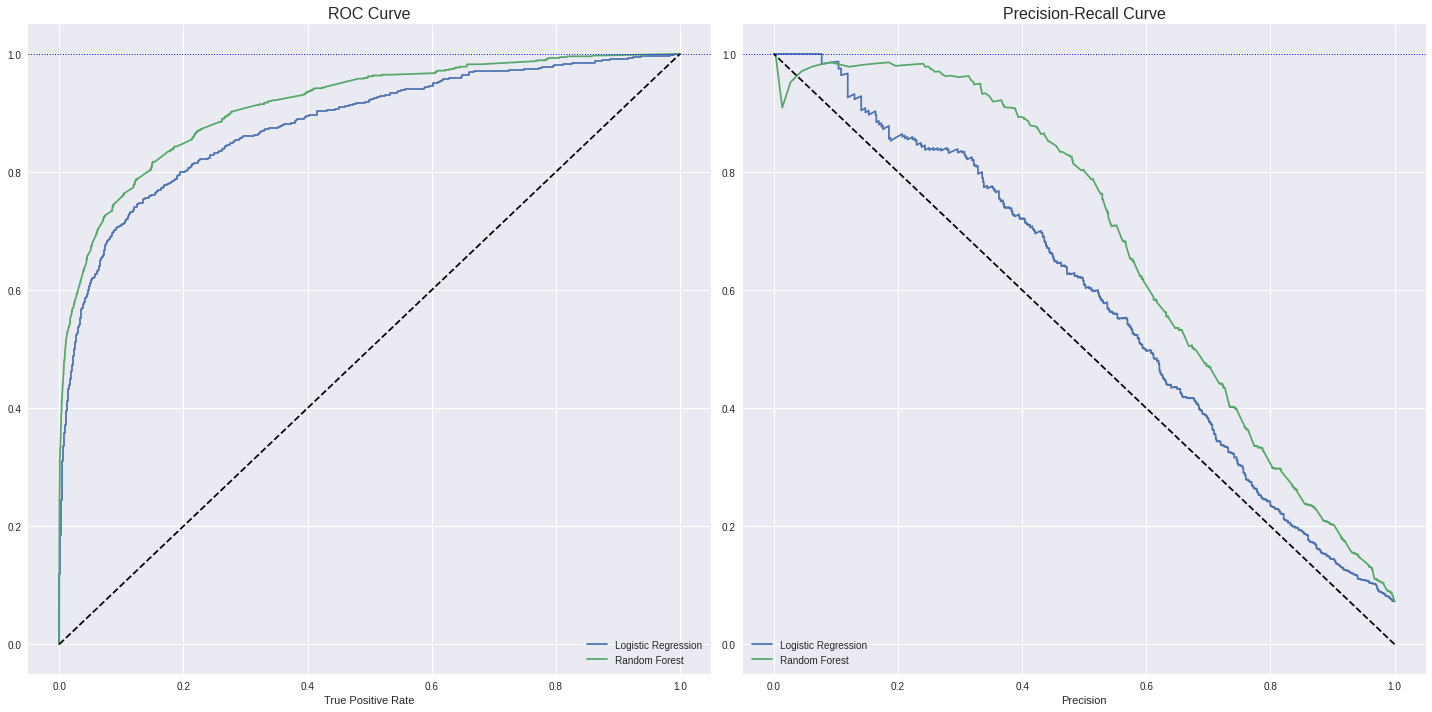

In [202]:
# ROC and PR curves
fig, ax= plt.subplots(1, 2, figsize=(20,10))

ax6 = ax[0]
ax6.set_title('ROC Curve', fontsize=16)
ax7=ax[1]
ax7.set_title('Precision-Recall Curve', fontsize=16)
for i in range(len(fpr_test_set)):
    # Plot ROC Curves
    ax6.plot(fpr_test_set[i], tpr_test_set[i], linestyle='-', 
             label=model_outcome.index[i],)
    # Plot Precision-Recall Curve
    ax7.plot(recall_test_set[i], precision_test_set[i],linestyle='-', 
             label=model_outcome.index[i],)
ax6.plot([0, 1], [0, 1], linestyle='--', color='black')
ax6.axhline(y=1, linestyle=':', linewidth=1, color='blue')
ax6.set_xlabel('False Positive Rate')
ax6.set_xlabel('True Positive Rate')
ax6.legend()

ax7.plot([1, 0], [0, 1], linestyle='--', color='black')
ax7.axhline(y=1, linestyle=':', linewidth=1, color='blue')
ax7.set_xlabel('Recall')
ax7.set_xlabel('Precision')
ax7.legend()

fig.tight_layout()
plt.show()

In [ ]:
plot_feature_importance(tuned_models1[0].best_estimator_.named_steps["Estimator"])

In [ ]:
test = pd.crosstab(raw_pt_icu.icu_adm_weekend, 
                   raw_pt_icu.icu_expire_flag,
                   normalize='index')
my_odds_and_risks(test)

In [ ]:
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2
# contingency table
# table = pd.crosstab(label_n_client.query('relationship_grouped!="Other" and relationship_to_client!="someone_else"').relationship_grouped, label_n_client.query('relationship_grouped!="Other" and relationship_to_client!="someone_else"')
#                     .shared_need).to_numpy()
table = test
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

In [ ]:
pd.crosstab(raw_pt_icu.icu_adm_weekend, raw_pt_icu.icu_expire_flag, normalize=True, )
#.\
#sort_index(ascending=False).T.sort_index(ascending=False).T

In [ ]:
plt.figure(figsize=(18, 10))
sns.distplot(raw_pt_icu.query('ttd_days>=0 and ttd_days <=30').ttd_days, bins=30, hist=True, kde=True,rug=False,
    hist_kws={"density":True, "histtype": "step", "linewidth": 6, "alpha": 0.6, "color": "g"})